#### testing MSE-based instability proxy and its relationship with MCS
- check if instability (thetae_850 - thetae_500) can protrait where MCS are located 

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from numba import jit, vectorize, float64
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

#### 2. PDFs of MSE-based instability: all vs MCS
- take the entire January as an example data

In [3]:
mask_dir = Path('/neelin2020/RGMA_feature_mask/data_product/2018/MERGED_FP')
ds_feat = xr.open_dataset(mask_dir / 'GPM_feature_merged_01_v4_mcsnew.nc')
mcs_mask = ds_feat.mcs_tag
ar_mask = ds_feat.ar_tag
ft_mask = ds_feat.front_c_tag
prec = ds_feat.precipitationCal

In [4]:
mse_dir = Path('/neelin2020/ERA-5_mse/2018')
ds_mse = xr.open_dataset(mse_dir / 'ERA-5.mse.2018.01.nc').sel(time=ds_feat.time, latitude=slice(60,-60))
ds_mse['dmse_w1'] = ds_mse.mse_850 - ds_mse.mse_sat_500
ds_mse['dmse_w05'] = (0.5*ds_mse.mse_850 + 0.5*ds_mse.mse_sfc) - ds_mse.mse_sat_500
ds_mse['dmse_w025'] = (0.25*ds_mse.mse_850 + 0.75*ds_mse.mse_sfc) - ds_mse.mse_sat_500
ds_tb = xr.open_dataset(mask_dir / '../MERGE-IR/Tb_MERGE_IR_2018_01_hrly.compress_new.nc').sel(time=ds_feat.time, method='nearest').sel(lat=slice(-60,60))
ds_tb = ds_tb.rename({'lat':'latitude','lon':'longitude'})
ds_tb['time'] = ds_feat.time.values

In [5]:
# match hourly MSE dataset and 6-hourly feature masks in time
ds_merged_6hrly = xr.merge([ds_mse, ds_feat, ds_tb])
ds_merged_6hrly

<xarray.Dataset> Size: 3GB
Dimensions:           (latitude: 481, longitude: 1440, time: 124)
Coordinates:
  * latitude          (latitude) float64 4kB -60.0 -59.75 -59.5 ... 59.75 60.0
  * longitude         (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * time              (time) datetime64[ns] 992B 2018-01-01 ... 2018-01-31T18...
    number            int64 8B ...
    expver            (time) <U4 2kB ...
Data variables: (12/14)
    mse_sfc           (time, latitude, longitude) float32 344MB 280.9 ... 291.5
    mse_850           (time, latitude, longitude) float32 344MB 278.5 ... 289.0
    mse_sat_500       (time, latitude, longitude) float32 344MB ...
    dmse_w1           (time, latitude, longitude) float32 344MB -18.76 ... -2...
    dmse_w05          (time, latitude, longitude) float32 344MB -17.57 ... -0...
    dmse_w025         (time, latitude, longitude) float32 344MB -16.98 ... -0...
    ...                ...
    front_c_tag       (time, latitude, longitude) int8 86MB ...
    front_w_tag       (time, latitude, longitude) int8 86MB ...
    front_s_tag       (time, latitude, longitude) int8 86MB ...
    lps_tag           (time, latitude, longitude) int8 86MB ...
    mcs_tag           (time, latitude, longitude) int8 86MB ...
    tb                (time, latitude, longitude) float32 344MB ...
Attributes:
    unit:          KJ/kg
    created date:  2024-10-21

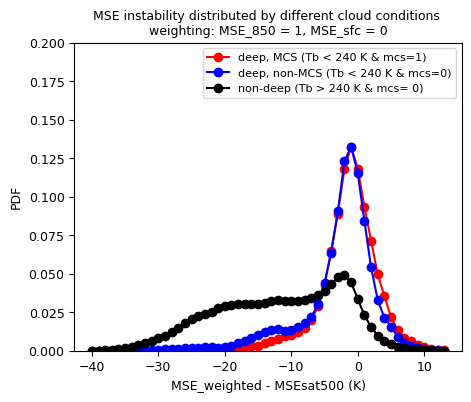

In [25]:
lat_bound = 30

mcs_map = ds_merged_6hrly.isel(time=slice(0,10)).mcs_tag.sel(latitude=slice(-lat_bound, lat_bound))
dmse_map = ds_merged_6hrly.isel(time=slice(0,10)).dmse_w1.sel(latitude=slice(-lat_bound, lat_bound))
prec_map = ds_merged_6hrly.isel(time=slice(0,10)).precipitationCal.sel(latitude=slice(-lat_bound, lat_bound))
tb_map = ds_merged_6hrly.isel(time=slice(0,10)).tb.sel(latitude=slice(-lat_bound, lat_bound))

dmse_mcs = dmse_map.where((mcs_map > 0))
dmse_deep = dmse_map.where((mcs_map == 0) & (tb_map <= 240))
dmse_noconv = dmse_map.where((mcs_map == 0) & (tb_map > 240))

tmp = dmse_mcs.values.ravel()
tmp = tmp[~np.isnan(tmp)]
tmp2 = dmse_deep.values.ravel()
tmp2 = tmp2[~np.isnan(tmp2)]
tmp3 = dmse_noconv.values.ravel()
tmp3 = tmp3[~np.isnan(tmp3)]
samples, bins_edge = np.histogram(tmp, bins=np.arange(-40,15))
samples2, bins_edge = np.histogram(tmp2, bins=np.arange(-40,15))
samples3, bins_edge = np.histogram(tmp3, bins=np.arange(-40,15))

fig = plt.figure(figsize=(5,4))
plt.plot(bins_edge[:-1], samples/samples.sum(), '-or', label='deep, MCS (Tb < 240 K & mcs=1)')
plt.plot(bins_edge[:-1], samples2/samples2.sum(), '-ob', label='deep, non-MCS (Tb < 240 K & mcs=0)')
plt.plot(bins_edge[:-1], samples3/samples3.sum(), '-ok', label='non-deep (Tb > 240 K & mcs= 0)')

plt.ylabel('PDF',fontsize=9)
plt.xlabel('MSE_weighted - MSEsat500 (K)',fontsize=9)
plt.tick_params(labelsize=9)
plt.legend(fontsize=8)
plt.title('MSE instability distributed by different cloud conditions \n' +
          'weighting: MSE_850 = 1, MSE_sfc = 0',fontsize=9)
plt.ylim([0,0.2])
plt.show()

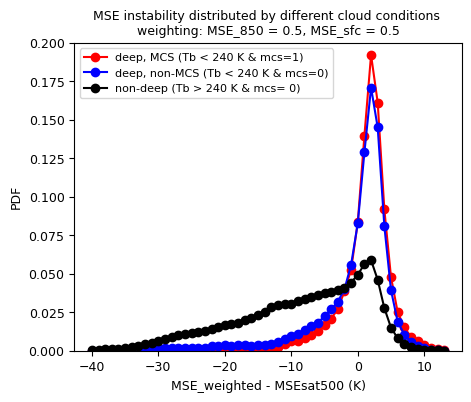

In [ ]:
lat_bound = 30

mcs_map = ds_merged_6hrly.isel(time=slice(0,10)).mcs_tag.sel(latitude=slice(-lat_bound, lat_bound))
dmse_map = ds_merged_6hrly.isel(time=slice(0,10)).dmse_w05.sel(latitude=slice(-lat_bound, lat_bound))
prec_map = ds_merged_6hrly.isel(time=slice(0,10)).precipitationCal.sel(latitude=slice(-lat_bound, lat_bound))
tb_map = ds_merged_6hrly.isel(time=slice(0,10)).tb.sel(latitude=slice(-lat_bound, lat_bound))

dmse_mcs = dmse_map.where((mcs_map > 0))
dmse_deep = dmse_map.where((mcs_map == 0) & (tb_map <= 240))
dmse_noconv = dmse_map.where((mcs_map == 0) & (tb_map > 240))

tmp = dmse_mcs.values.ravel()
tmp = tmp[~np.isnan(tmp)]
tmp2 = dmse_deep.values.ravel()
tmp2 = tmp2[~np.isnan(tmp2)]
tmp3 = dmse_noconv.values.ravel()
tmp3 = tmp3[~np.isnan(tmp3)]
samples, bins_edge = np.histogram(tmp, bins=np.arange(-40,15))
samples2, bins_edge = np.histogram(tmp2, bins=np.arange(-40,15))
samples3, bins_edge = np.histogram(tmp3, bins=np.arange(-40,15))

fig = plt.figure(figsize=(5,4))
plt.plot(bins_edge[:-1], samples/samples.sum(), '-or', label='deep, MCS (Tb < 240 K & mcs=1)')
plt.plot(bins_edge[:-1], samples2/samples2.sum(), '-ob', label='deep, non-MCS (Tb < 240 K & mcs=0)')
plt.plot(bins_edge[:-1], samples3/samples3.sum(), '-ok', label='non-deep (Tb > 240 K & mcs= 0)')

plt.ylabel('PDF',fontsize=9)
plt.xlabel('MSE_weighted - MSEsat500 (K)',fontsize=9)
plt.tick_params(labelsize=9)
plt.legend(fontsize=8)
plt.title('MSE instability distributed by different cloud conditions \n' +
          'weighting: MSE_850 = 0.5, MSE_sfc = 0.5',fontsize=9)
plt.ylim([0,0.2])
plt.show()

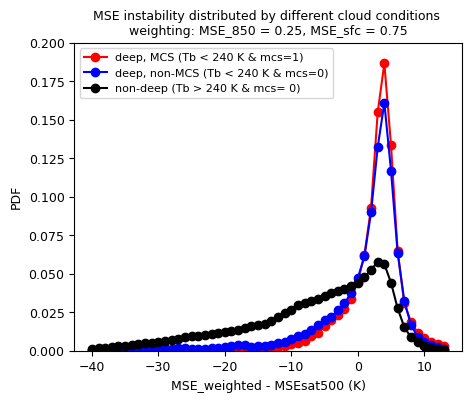

In [27]:
lat_bound = 30

mcs_map = ds_merged_6hrly.isel(time=slice(0,10)).mcs_tag.sel(latitude=slice(-lat_bound, lat_bound))
dmse_map = ds_merged_6hrly.isel(time=slice(0,10)).dmse_w025.sel(latitude=slice(-lat_bound, lat_bound))
prec_map = ds_merged_6hrly.isel(time=slice(0,10)).precipitationCal.sel(latitude=slice(-lat_bound, lat_bound))
tb_map = ds_merged_6hrly.isel(time=slice(0,10)).tb.sel(latitude=slice(-lat_bound, lat_bound))

dmse_mcs = dmse_map.where((mcs_map > 0))
dmse_deep = dmse_map.where((mcs_map == 0) & (tb_map <= 240))
dmse_noconv = dmse_map.where((mcs_map == 0) & (tb_map > 240))

tmp = dmse_mcs.values.ravel()
tmp = tmp[~np.isnan(tmp)]
tmp2 = dmse_deep.values.ravel()
tmp2 = tmp2[~np.isnan(tmp2)]
tmp3 = dmse_noconv.values.ravel()
tmp3 = tmp3[~np.isnan(tmp3)]
samples, bins_edge = np.histogram(tmp, bins=np.arange(-40,15))
samples2, bins_edge = np.histogram(tmp2, bins=np.arange(-40,15))
samples3, bins_edge = np.histogram(tmp3, bins=np.arange(-40,15))

fig = plt.figure(figsize=(5,4))
plt.plot(bins_edge[:-1], samples/samples.sum(), '-or', label='deep, MCS (Tb < 240 K & mcs=1)')
plt.plot(bins_edge[:-1], samples2/samples2.sum(), '-ob', label='deep, non-MCS (Tb < 240 K & mcs=0)')
plt.plot(bins_edge[:-1], samples3/samples3.sum(), '-ok', label='non-deep (Tb > 240 K & mcs= 0)')

plt.ylabel('PDF',fontsize=9)
plt.xlabel('MSE_weighted - MSEsat500 (K)',fontsize=9)
plt.tick_params(labelsize=9)
plt.legend(fontsize=8)
plt.title('MSE instability distributed by different cloud conditions \n' +
          'weighting: MSE_850 = 0.25, MSE_sfc = 0.75',fontsize=9)
plt.ylim([0,0.2])
plt.show()